In [2]:
binarize = False
model_type = "forecaster"
remove_trend = False # Bad parameters (decrease performance)
lag_features = False
use_raw = True

save_model = False
model_name = "XGBReg"
parameters = "lagfeatures_removetrend_betterfeatures"

In [11]:
import pandas as pd
from src.models import build_model
from src.processing import process_features,process_target, impute_na
from src.evaluation import evaluate, evaluate_forecaster

# Inport SVR model
from sklearn.svm import SVR
import darts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
if use_raw:
    x_train_raw = pd.read_csv("data/x_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
    y_train_raw = pd.read_csv("data/y_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
    x_test_raw = pd.read_csv("data/x_test.csv", index_col= 'DELIVERY_START', parse_dates=True)

    x_train, x_train_indices = impute_na(x_train_raw)
    x_test, x_test_indices = impute_na(x_test_raw)
    y_train, y_train_indices = impute_na(y_train_raw)

proc_x_train, proc_x_test = process_features(x_train,x_test,remove_trend=remove_trend, lag_features=lag_features)
proc_y_train = process_target(y_train, binarize=binarize)

COLUMN :  load_forecast
COLUMN :  coal_power_available
Could not decompose coal_power_available into trend/seasonality, doing simple interpolation
COLUMN :  gas_power_available


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/src/processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
COLUMN :  solar_power_forecasts_average
COLUMN :  wind_power_forecasts_std
COLUMN :  solar_power_forecasts_std
COLUMN :  predicted_spot_price
Could not decompose predicted_spot_price into trend/seasonality, doing simple interpolation
COLUMN :  original


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/src/processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


COLUMN :  load_forecast
COLUMN :  coal_power_available
COLUMN :  gas_power_available
COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
COLUMN :  solar_power_forecasts_average
COLUMN :  wind_power_forecasts_std
COLUMN :  solar_power_forecasts_std
COLUMN :  predicted_spot_price
Could not decompose predicted_spot_price into trend/seasonality, doing simple interpolation
COLUMN :  original
COLUMN :  spot_id_delta
COLUMN :  original


/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/src/processing.py:152: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp[column] = df_temp[column].fillna(method = 'ffill')


## Evaluation

/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/mnt/windows/Users/tmdu1/Documents/Thomas/ENS/M2/Cours/Echantillonnage/data_challenge_elmy/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)`

0.4944646536971584


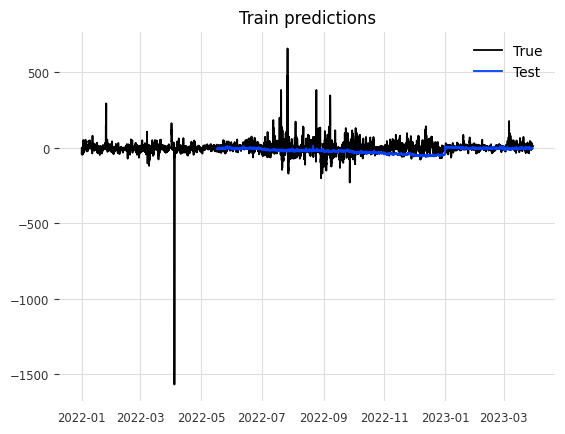

In [16]:
# Split data
N_train = int(len(proc_x_train)*0.3)
x_train_eval, x_test_eval = process_features(x_train[:N_train], x_train[N_train:], remove_trend=remove_trend, lag_features=lag_features)
y_train_eval, y_test_eval = y_train[:N_train], y_train[N_train:]
y_train_eval = process_target(y_train_eval, binarize=binarize)

# Train model
model = build_model(type=model_type)
if model_type == "forecaster":
    y = darts.timeseries.TimeSeries.from_series(y_train_eval)
    X = darts.timeseries.TimeSeries.from_series(x_train_eval)
    model.fit(y, future_covariates=X)
else:
    model.fit(x_train_eval, y_train_eval)

# Evaluate model
# print(evaluate(model, x_test_eval, y_test_eval, x_train_indices[0][x_train_indices[0]>=N_train]-N_train))
print(evaluate_forecaster(model, x_test_eval, y_test_eval, x_train_indices[0][x_train_indices[0]>=N_train]-N_train))

# Visualize predictions
import matplotlib.pyplot as plt
if model_type == "forecaster":
    #y_train_pred = model.predict(N_train,future_covariates=X)
    y_test_pred = model.predict(len(proc_x_train)- N_train,future_covariates=darts.timeseries.TimeSeries.from_series(x_test_eval))
    y_test_pred = y_test_pred.pd_dataframe().squeeze()
else:
    y_train_pred = model.predict(x_train_eval)
    y_test_pred = model.predict(x_test_eval)

# Plot predictions
plt.plot(y_train.index, y_train, label='True')
if model_type != "forecaster":
    plt.plot(x_train_eval.index, y_train_pred, label='Predicted')
plt.plot(x_test_eval.index, y_test_pred, label='Test')
plt.title('Train predictions')
plt.legend()
plt.show()


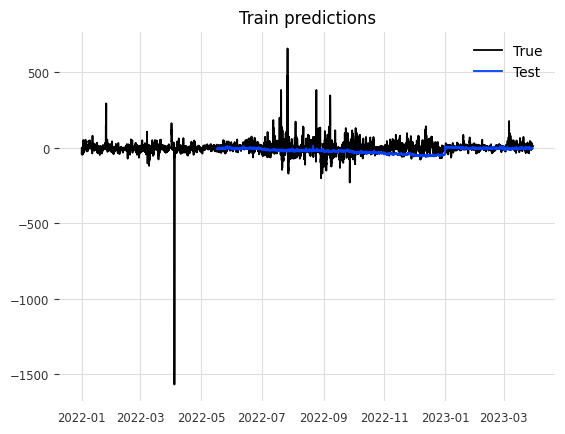

In [10]:
plt.plot(y_train.index, y_train, label='True')
#plt.plot(x_train_eval.index, y_train_pred, label='Predicted')
plt.plot(x_test_eval.index, y_test_pred.all_values().squeeze(), label='Test')
plt.title('Train predictions')
plt.legend()
plt.show()

## Prepare submission

In [ ]:
# Fit with full data
model = build_model(type=model_type)
model.fit(proc_x_train, proc_y_train);

In [ ]:
if save_model:
    from datetime import datetime
    y_test_pred = model.predict(proc_x_test)
    print(len(y_test_pred))
    y_test_pred = y_test_pred[x_test_indices[0]]
    print(len(y_test_pred))
    y_test_pred = pd.DataFrame(y_test_pred, index=x_test_raw.index, columns=['spot_id_delta'])
    y_test_pred.to_csv(f'submission/{datetime.today().date()}_{model_name}_{parameters}.csv', index=True)

4944
4942
